# Создание простой рекомендательной системы на Python

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import matplotlib.pyplot as plt     
%matplotlib inline                 
import seaborn as sns         
import pandas as pd  
import numpy as np  

В этом разделе мы разработаем очень простую систему рекомендаций фильмов на Python, которая использует корреляцию между рейтингами, присвоенными различным фильмам, чтобы найти сходство между фильмами.

In [ ]:
ratings_data = pd.read_csv('/content/drive/MyDrive/recomm_syst/ratings.csv')
ratings_data.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [ ]:
movie_names = pd.read_csv('/content/drive/MyDrive/recomm_syst/movies.csv')
movie_names.head()


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
movie_data = pd.merge(ratings_data, movie_names, on = 'movieId' )
movie_data.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


Теперь давайте посмотрим на средний рейтинг каждого фильма. Для этого мы можем сгруппировать набор данных по названию фильма, а затем вычислить среднее значение рейтинга для каждого фильма.

In [ ]:
movie_data.groupby('title')['rating'].mean().sort_values(ascending = False).head()

title
Karlson Returns (1970)                           5.0
Winter in Prostokvashino (1984)                  5.0
My Love (2006)                                   5.0
Sorority House Massacre II (1990)                5.0
Winnie the Pooh and the Day of Concern (1972)    5.0
Name: rating, dtype: float64

Фильмы теперь отсортированы в порядке возрастания их рейтингов. Однако есть одна проблема. Фильм может занять первое место в вышеприведенном списке, даже если только один пользователь дал ему пять звезд. Поэтому приведенные выше статистические данные могут вводить в заблуждение. Обычно фильм, который действительно хорош, получает более высокий рейтинг у большого числа пользователей.

In [ ]:
movie_data.groupby('title')['rating'].count().sort_values(ascending = False).head()

title
Forrest Gump (1994)                 329
Shawshank Redemption, The (1994)    317
Pulp Fiction (1994)                 307
Silence of the Lambs, The (1991)    279
Matrix, The (1999)                  278
Name: rating, dtype: int64

Средний рейтинг и количество оценок - важные атрибуты. Добавим их в таблицу:

In [ ]:
ratings_mean_count = pd.DataFrame()
ratings_mean_count['mean_rating'] = movie_data.groupby('title')['rating'].mean()
ratings_mean_count['rating_counts'] = movie_data.groupby('title')['rating'].count()
ratings_mean_count.head()

,mean_rating,rating_counts
title,,
'71 (2014),4.0,1
'Hellboy': The Seeds of Creation (2004),4.0,1
'Round Midnight (1986),3.5,2
'Salem's Lot (2004),5.0,1
'Til There Was You (1997),4.0,2


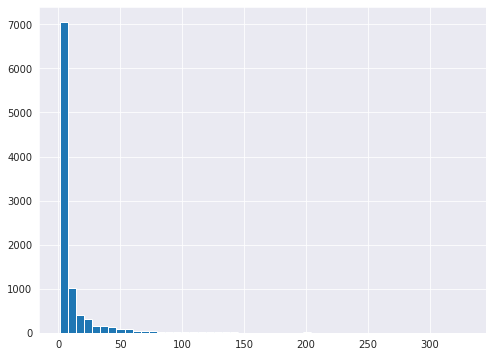

In [ ]:
sns.set_style('dark') # построение гистограммы

plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['rating_counts'].hist(bins=50)


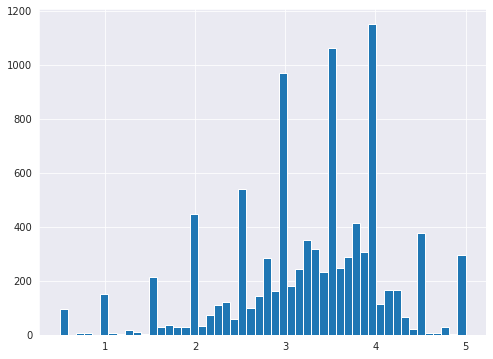

In [ ]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['mean_rating'].hist(bins=50) # гистограмма средних оценок

Вы можете видеть, что целочисленные значения имеют более высокие бары, чем плавающие значения, так как большинство пользователей присваивают рейтинг как целочисленное значение, то есть 1, 2, 3, 4 или 5. Кроме того, очевидно, что данные имеют слабое нормальное распределение со средним значением около 3,5. В данных есть несколько выбросов.

<Figure size 576x432 with 0 Axes>

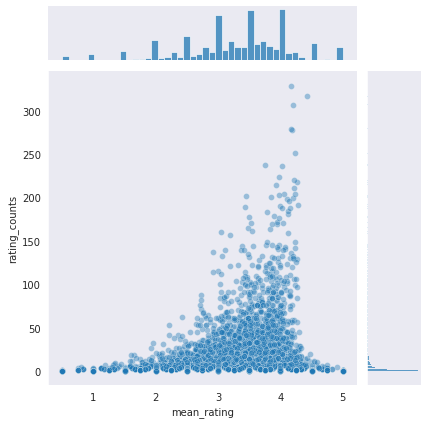

In [ ]:
plt.figure(figsize=(8,6)) # средние рейтинги и количество голосов
plt.rcParams['patch.force_edgecolor'] = True
sns.jointplot(x='mean_rating', y='rating_counts', data=ratings_mean_count, alpha=0.4)

График показывает, что в целом фильмы с более высокими средними рейтингами на самом деле имеют большее количество рейтингов по сравнению с фильмами с более низкими средними рейтингами.

# Поиск сходства между фильмами

Матрица названий фильмов и соответствующих пользовательских рейтингов 
(разреженная)

In [ ]:
user_movie_rating = movie_data.pivot_table(index='userId', columns='title', values='rating')
user_movie_rating.head()

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...All the Marbles (1981),...And Justice for All (1979),00 Schneider - Jagd auf Nihil Baxter (1994),1-900 (06) (1994),10 (1979),10 Cent Pistol (2015),10 Cloverfield Lane (2016),10 Items or Less (2006),10 Things I Hate About You (1999),10 Years (2011),"10,000 BC (2008)",100 Girls (2000),100 Streets (2016),101 Dalmatians (1996),101 Dalmatians (One Hundred and One Dalmatians) (1961),101 Dalmatians II: Patch's London Adventure (2003),101 Reykjavik (101 Reykjavík) (2000),102 Dalmatians (2000),10th & Wolf (2006),"10th Kingdom, The (2000)","10th Victim, The (La decima vittima) (1965)","11'09""01 - September 11 (2002)",11:14 (2003),"11th Hour, The (2007)",12 Angry Men (1957),12 Angry Men (1997),12 Chairs (1971),12 Chairs (1976),12 Rounds (2009),12 Years a Slave (2013),...,Zathura (2005),Zatoichi and the Chest of Gold (Zatôichi senryô-kubi) (Zatôichi 6) (1964),Zazie dans le métro (1960),Zebraman (2004),"Zed & Two Noughts, A (1985)",Zeitgeist: Addendum (2008),Zeitgeist: Moving Forward (2011),Zeitgeist: The Movie (2007),Zelary (2003),Zelig (1983),Zero Dark Thirty (2012),Zero Effect (1998),"Zero Theorem, The (2013)",Zero de conduite (Zero for Conduct) (Zéro de conduite: Jeunes diables au collège) (1933),Zeus and Roxanne (1997),Zipper (2015),Zodiac (2007),Zombeavers (2014),Zombie (a.k.a. Zombie 2: The Dead Are Among Us) (Zombi 2) (1979),Zombie Strippers! (2008),Zombieland (2009),Zone 39 (1997),"Zone, The (La Zona) (2007)",Zookeeper (2011),Zoolander (2001),Zoolander 2 (2016),Zoom (2006),Zoom (2015),Zootopia (2016),Zulu (1964),Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
forrest_gumps_rating = user_movie_rating['Forrest Gump (1994)']
forrest_gumps_rating.head()

userId
1    4.0
2    NaN
3    NaN
4    NaN
5    NaN
Name: Forrest Gump (1994), dtype: float64

Теперь давайте восстановим все фильмы, которые похожи на “Форрест Гамп (1994)”. Мы можем найти корреляцию между пользовательскими рейтингами “Форрест Гамп (1994)” и всех других фильмов, используя функцию corr with () , как показано ниже:

In [ ]:
movies_like_forest_gump = user_movie_rating.corrwith(forrest_gumps_rating)

corr_forrest_gump = pd.DataFrame(movies_like_forest_gump, columns=['Correlation'])
corr_forrest_gump.dropna(inplace=True)
corr_forrest_gump.head()


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


,Correlation
title,
"'burbs, The (1989)",0.197712
(500) Days of Summer (2009),0.234095
*batteries not included (1987),0.892710
...And Justice for All (1979),0.928571
10 Cent Pistol (2015),-1.000000


In [ ]:
corr_forrest_gump.sort_values('Correlation', ascending = False).head()

,Correlation
title,
Lost & Found (1999),1.0
"Century of the Self, The (2002)",1.0
The 5th Wave (2016),1.0
Play Time (a.k.a. Playtime) (1967),1.0
Memories (Memorîzu) (1995),1.0


Из выходных данных видно, что фильмы, имеющие высокую корреляцию с “Форрестом Гампом (1994)”, не очень хорошо известны. Это показывает, что корреляция сама по себе не является хорошим показателем сходства, потому что может быть пользователь, который смотрел”Форест Гамп (1994)” и только один другой фильм и оценил их оба как 5.

Решение этой проблемы состоит в том, чтобы извлекать только те коррелированные фильмы, которые имеют по крайней мере более 50 рейтингов. Для этого добавим столбец rating_counts из фрейма данных rating_mean_count в наш фрейм данных corre_forrest_gump . Для этого выполните следующий сценарий:

In [ ]:
corr_forrest_gump = corr_forrest_gump.join(ratings_mean_count['rating_counts'])

In [ ]:
corr_forrest_gump.head()

,Correlation,rating_counts
title,,
"'burbs, The (1989)",0.197712,17
(500) Days of Summer (2009),0.234095,42
*batteries not included (1987),0.892710,7
...And Justice for All (1979),0.928571,3
10 Cent Pistol (2015),-1.000000,2


Фильтруем фрейм по количеству голосов > 50

In [ ]:
corr_forrest_gump[corr_forrest_gump.rating_counts > 50].sort_values('Correlation', ascending = False).head()

,Correlation,rating_counts
title,,
Forrest Gump (1994),1.000000,329
Mr. Holland's Opus (1995),0.652144,80
Pocahontas (1995),0.550118,68
Grumpier Old Men (1995),0.534682,52
Caddyshack (1980),0.520328,52


Теперь вы можете увидеть на выходе фильмы, которые сильно коррелируют с “Форрестом Гампом (1994)”.